# Project 3: Clustering
**Group 5:** Jeff Nguyen, William Hinton, Adam Ruthford  
**09AUG2020**

# Business Understanding

# Data Understanding 1

Initial data cleaning and preparation code was derived from **Project 1**, where data types and null values were addressed.  Data were first imported into a pandas dataframe, followed by each feature getting set to the appropriate data type based on data dictionary definitions.  For example, features that have currencies are set to the float data type as they are a continuous feature; whereas features like **NewExist** is categorical in nature and set to the object data type.

In [1]:
#Import data manipulation, vizulization, and ML Packages
import pandas as pd
import time
nbstart = time.time()
#load data into pandas dataframe
loans = pd.read_csv('C:/Users/Jeff/Desktop/ML1/SBAnational.csv')
#loans = pd.read_csv('C:\Data\DS7331\Project\should-this-loan-be-approved-or-denied/SBAnational.csv')

C:\Users\Jeff\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**DisbursementGross**, **BalanceGross**, **ChgOffPrinGr**, **GrAppv**, **SBA_Appv** are features that deal with currency and are coded as strings which include '$' and ',' characters. Used this website for help with [converting currency to float.](
https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas)

To treat these features as continuous data the special characters were removed, and the data was converted to the float data type.  This will allow for the data to be used by methods that utilize continous data.  **ApprovalDate**, **ChgOffDate**, and **DisbursementDate** are features that contain dates and were converted to the date/time data type.  This will be usefull for potential time series analysis.  **NewExist** is a categorical feature but has a float data type.  This feature was converted to an integer data type since float is better suited for continuous data.  **Zip**, **NAICS**, **FranchiseCode** are nominal features, but will be converted to strings for ease of manipulation and data cleaning.

In [2]:
import numpy as np

# Create lists of features that need their data types converted
currency = ['DisbursementGross','BalanceGross','ChgOffPrinGr','GrAppv','SBA_Appv']
date = ['ApprovalDate','ChgOffDate','DisbursementDate']
cat_variables = ['Zip']

# Convert features to appropriate data types
loans[currency] = loans[currency].replace('[\$,]', '', regex=True).astype(float)
loans[date]= loans[date].astype(np.datetime64)
loans['NewExist'] = loans['NewExist'].astype('Int64')
loans[cat_variables] = loans[cat_variables].astype(str)

Several null values were also present in the City and State features. City contained 14 null values and State contained 30 null values. Both features describe the loan applicant's address information. For City null values, zip codes from the Zip feature and the United States Postal Service Zip Code Lookup tool (https://tools.usps.com/zip-code-lookup.htm?citybyzipcode) were used to identify the correct city or state name. Two zip-codes in City feature and two zip-codes in the State feature did not return a city in the United States and were left as 'NaN'. Since there are only 4 rows of data that do not have proper city or state data, they will be kept or removed depending on the machine learning algorithm used.

In [3]:
# Replace City NA with appropriate state/city name
cityList = ['Salt Lake City','New Orleans','Chicago','Chicago','San Diego','San Diego','San Diego','San Diego',
            'San Diego','San Diego','Clevland','St. Louis','St. Louis','St. Louis','St. Louis','St. Louis',
            'St. Louis','Seattle','Des Moines','San Antonio','Kansas City','Kansas City','Quincy','Quincy','Boston',
            'NaN','NaN','Louisville','Wilmington','Flint']
stateList = ['NaN','NaN','CA','AP','KS','TX','FL','WI','NJ','UT','MO','TX','TX','TX']

#Replace Cities with NAs with appropriate City or State    
loans.loc[loans.City.isnull(),'City'] = cityList
loans.loc[loans.State.isnull(),'State'] = stateList

A new feature called **difference_in_days** was created by subtracting DisbursementDate minus ApprovalDate.  This will explain the relationship between time the loan was approved to disbursement date. There may be some correlation to why a loan is defaulted on depending on disbursement date.

In [4]:
#Create new Time feature and convert to int
from datetime import datetime, timedelta
d1 = loans.DisbursementDate
d2 = loans.ApprovalDate
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%d-%m-%Y")
    d2 = datetime.strptime(d2, "%d-%m-%Y")
    return abs((d2 - d1).days)

difference_in_days = abs((d2-d1))/ timedelta(days=1)

loans['difference_in_days'] = difference_in_days

Addressing 1997 null records for MIS_Status was unique in that it was depedent on several attributes in the dataset. There were four different combinations of code used to address the null records for this feature. The first combination identified null values that had a non-null value in the ChgOffDate feature and that the ChgOffPrinGr feature was not equal to zero; this combination of conditional requirements identified records that defaulted and had a charge off balance and renamed the null values as "CHGOFF". The second combination identified null values where DisbursementDate was not null and the BalanceGross was equal to zero; this combination of features identifies records that did not receive funds and do not have a balance, this labeled the null values as "P I F". The third and fourth combination identify null MIS_Status records where funds were not disbursed by checking DisbursementGross and BalanceGross features. If the DisbursementGross was zero or null and the BalanceGross was 0, the missing data was labels as "Not Disbursed".


In [5]:
loans['MIS_Status'].isnull().sum()

1997

In [6]:
#--------------------------------------------------------------------------------------------------------------------
#Fill In NaN fields
loans.dropna(subset = ['Name'], inplace = True)
loans["Bank"].fillna("Not Listed", inplace = True) 
loans["BankState"].fillna("Not Listed", inplace = True) 
loans['NewExist'].fillna(0, inplace = True)
loans['RevLineCr'].fillna("Not Provided", inplace = True)
loans['LowDoc'].fillna("Not Provided", inplace = True)
#loans['ChgOffDate'].fillna("0000-00-00",inplace = True)
#loans['DisbursementDate'].fillna("0000-00-00",inplace = True)

#Replace NaT MIS_status with CHGOFF if their ChgOffDate is not null
#If MIS_Status has value, 
loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) & 
                         ((loans['ChgOffDate'].notnull()) |
                          (loans['ChgOffPrinGr']!=0.0)),'CHGOFF',inplace=True) 

loans['MIS_Status'].isnull().sum()

1736

In [7]:
loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) &
                         (loans['DisbursementDate'].notnull()) & 
                         (loans['BalanceGross']==0.0),'P I F',inplace=True)

loans['MIS_Status'].isnull().sum()

117

In [8]:
loans['MIS_Status'].mask((loans['MIS_Status'].isnull()) &
                         (loans['DisbursementGross']==0.0) & 
                         (loans['BalanceGross']==0.0),'Not Disbursed',inplace=True)
print(loans['MIS_Status'].isnull().sum())

##Delete these records

36


In [9]:
loans.drop(loans[loans['MIS_Status'] == 'Not Disbursed'].index,inplace = True)
loans = loans.reset_index(drop=True) 
print(loans.shape)

(899069, 28)


In [10]:
loans['MIS_Status'].isnull().sum()
# delete these records instead

36

In [11]:
#--------------------------------------------------------------------------------------------------------------------
loans['MIS_Status'].replace(to_replace = 'P I F', value = 1, inplace = True)
loans['MIS_Status'].replace(to_replace = 'CHGOFF', value = 0, inplace = True)

After null values were removed, the index was reset for the loans data frame.  When rows are removed from a data frame, the index for that row remains.  If the indcies are not reset, null values will be assigned to indicies that had rows removed. Since sklearn algorithms require matricies and arrays, when a data frame with surplus incies are converted to a matrix, there will be a shape mismatch causing an error.  The .info() function was run to check on null values and the range index.

In [12]:
loans = loans.reset_index(drop=True) #resets index, important when converting to array

In [13]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899069 entries, 0 to 899068
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LoanNr_ChkDgt       899069 non-null  int64         
 1   Name                899069 non-null  object        
 2   City                899069 non-null  object        
 3   State               899069 non-null  object        
 4   Zip                 899069 non-null  object        
 5   Bank                899069 non-null  object        
 6   BankState           899069 non-null  object        
 7   NAICS               899069 non-null  int64         
 8   ApprovalDate        899069 non-null  datetime64[ns]
 9   ApprovalFY          899069 non-null  object        
 10  Term                899069 non-null  int64         
 11  NoEmp               899069 non-null  int64         
 12  NewExist            899069 non-null  Int64         
 13  CreateJob           899069 no

## Response and Explanatory Feature Descriptions, and Feature Engineering

### Response Feature

Three features in the SBAnational dataset can serve as response variables.  Two are continuous and one is categorical.  These features were choosen to be response variables as they are good indicators of loan success or failure.

**CreateJob and RetainedJob:** These columns are presented as an integer. The column records the number of jobs created or retained, respectively. These variables cannot be used as explanatory variables as they indicate the success of the loan. They are a proxy for loan success. However, these variables can be used as the response variable in a model that would attempt to maximize job creation and or retention. Thus, any of these response terms correlated with explanatory terms are significant and noteworthy due to their possible predictive power.  Since we are more interested in the classification of accounts having paid in full or were charged off; these featuers will be exclued from the model.

**MIS_Status:** This column is presented as an object/string. The column is categorical data with values "P I F" and "CHGOFF". This column is the main response column of the dataset.  This feature will be used to determine if a loan has succeeded or failed, where 'P I F' is a success, and a 'CHGOFF' is a failure.  Approximately 18% of loans were marked for a 'CHGOFF' and 82% successful repaid their loans.  This feature will serve as the response feature for our logistic and SVM models as it is dichotmous and indicates whether or not a loan applicant has paid their loan back or not.  **MIS_Status** will also be converted to numeric values instead of character for use in the model.

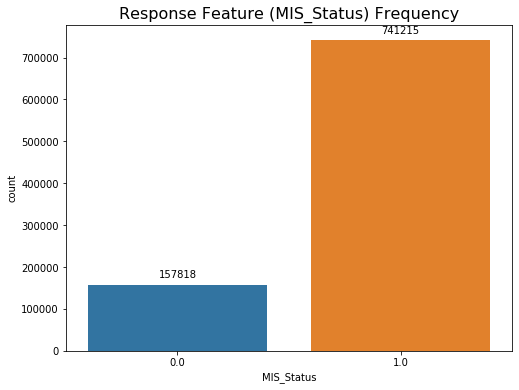

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.countplot(x =loans['MIS_Status'] )
plt.title("Response Feature (MIS_Status) Frequency",fontsize= 16)

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()),  ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

**ApprovalDate**, **DisbursementDate**, and **ChgOffDate** are features that contain dates.  Since there are a large volume of dates, these features would not be suited for conversion to categorical features unless they were binned.  **ApprovalFY** is similar to **ApprovalDate** and may better be suited for use in the model; this feature can be binned to reduce the number of levels in the feature. This model does not address time series analysis or autocorrelation structures.  If a record contains a value from **ChgOffDate**, then the loan defaulted.  This information is more sussenctly captured in the **MIS_Status** level 'CHGOFF'; due to the redundancy **ChgOffDate** would be more useful in a new feature that captures a time difference with another time feild.

One assumption for logistic regression is minimal multicollinearity.  **DisbursmentGross**, **GRAppv**, and **SBA_Appv** are highly correlated (r > 0.90) with each other as they all describe the amount of money that is given to a loan applicant. **SBA_Appv** will be kept, while **DisbursementGross** and **GrAppv** will be removed as they are both like **SBA_Appv**, but do not represent the final loan amount an applicant will receive.  Please see the correlation matrix in the **Data Preparation** section for more details.

**LoannNr_ChkDgt** is the primary key for this dataset.  They were removed.   
**Name** remove – there was no need to know the name of the loan applicate or business.  
**City** remove - how this might be useful we decided that there is no need to have city due to loans can originate from different cities where the applicant works and uses the loan.   
**Zip** remove – it is ideal to have the zip code of where the loan originated so we can see where the demographics of most loans are generated but that is not part of this exercise, so we got rid of the zip.   
**BankState** remove – this is not good to use because well known banks will be in most popular area and not the rural area. The demographic is skewed as we have identified in the bank state demographic graph.   
**ChgOffDate** remove – once a loan has defaulted, there is a charge off date. We are not using it.   
**Term** keep – this is a good indicator to determine if the loan will be defaulted due to the terms, some loans have short terms and most of them have long terms.   
**NoEmp** keep – this is the number of employees generated from the loan.    
**FranchiseCode** keep – this indicates what type of businesses are requesting loans and which ones are likely to pay back the loan.    
**BalanceGross** keep – this variable indicates how much needs to be repaid. Larger loan might have large balances if they are not paid back quickly.  


### Feature Engineering

**State**, **Bank**, **NAICS**, **ApprovalFY, **NewExist**, **UrbanRural**, **RevlineCr**, and **LowDoc** are features that require binning and/or one-hot-encoding.  These features may require additional cleaning and may have many categories.  Consolidating the number of categories can assist with reducing overfitting and reduce the computational load it would take to find weights for the numerous levels that exist in some of the features.

#### Categorical Features

**Bank** contains over 5,803 unique levels.  Using this many levels in a model may lead to overfitting.  To avoid this situation the large volume of banks will be reduced by consolidating and binning into nine bins.  These bins will contain the top eight banks, and an 'other' category containing the other smaller banks.  The other category was created by renaming all banks that were not in the 'major_banks' list to 'other'.  The .describe() function was then run on the modified feature to confirm that the correct number of categories were created.

In [15]:
loans['Bank'].value_counts().head(15)

BANK OF AMERICA NATL ASSOC        86847
WELLS FARGO BANK NATL ASSOC       63491
JPMORGAN CHASE BANK NATL ASSOC    48160
U.S. BANK NATIONAL ASSOCIATION    35142
CITIZENS BANK NATL ASSOC          35053
PNC BANK, NATIONAL ASSOCIATION    27351
BBCN BANK                         22978
CAPITAL ONE NATL ASSOC            22247
MANUFACTURERS & TRADERS TR CO     11262
READYCAP LENDING, LLC             10664
THE HUNTINGTON NATIONAL BANK       9605
KEYBANK NATIONAL ASSOCIATION       9259
TD BANK, NATIONAL ASSOCIATION      9007
BRANCH BK. & TR CO                 8262
ZIONS FIRST NATIONAL BANK          7954
Name: Bank, dtype: int64

In [16]:
# Banks create buckets for top 19 banks + other
major_bank = ['BANK OF AMERICA NATL ASSOC', 'WELLS FARGO BANK NATL ASSOC',
              'JPMORGAN CHASE BANK NATL ASSOC','U.S. BANK NATIONAL ASSOCIATION',
              'CITIZENS BANK NATL ASSOC','PNC BANK, NATIONAL ASSOCIATION',
             'BBCN BANK','CAPITAL ONE NATL ASSOC']

loans.loc[~loans["Bank"].isin(major_bank), "Bank"] = "Other"

A barchart was also created for the modified **Bank** to visually confirm that there are eight major banks followed by an 'other' category.  We can see that the Bank of America is one of the larger banks by loan applicaiton volume followed by Wells Fargo.  However, many loans are aquired through other banks, perhaps many of them local.  A for loop was applied to show the frequencies of loans that the banks have per bin.

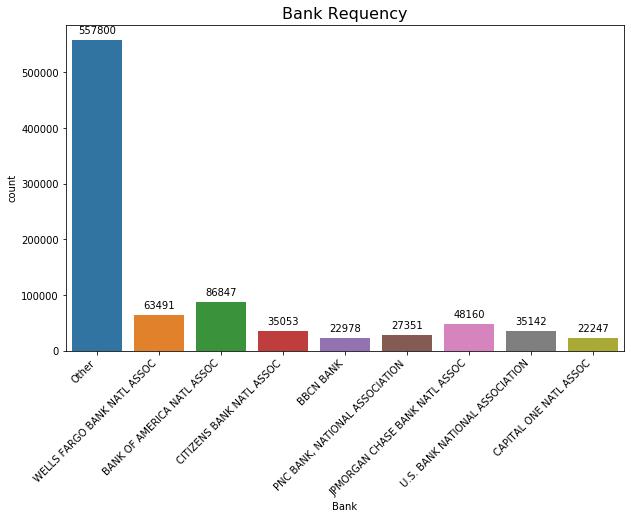

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x =loans['Bank'] )
plt.title("Bank Requency",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:#provides frequency counts
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()),  ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

The North American Industry Classification System (**NAICS**) is used to classify a business into 19+ sectors that specialize in different services.  To reduce the number of levels, sectors were grouped based on similar attributes. The list of sectors can be viewed in the 'Data Dictionary' section of this link:https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied?select=SBAnational.csv 

Sectors were grouped by the first digit in their code as seen below:
- 1 Agriculture
- 2 Mining, Utilities, Construction
- 3 Manufacturing
- 4 Trade and Transportation
- 5 Professional and Scientific
- 6 Education and Health
- 7 Arts and Hospitality
- 8 other
- 9 Public Administration


In [18]:
# create NAICS bins for 0,1,2,3,4,5,6,7,8,9
'NAICS'
loans['NAICS'].replace(to_replace = 0, value = 800000, inplace = True)
loans['NAICS']= pd.cut(loans['NAICS'],
                       [100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000],
                       labels = ['1','2','3','4','5','6','7','8','9'])

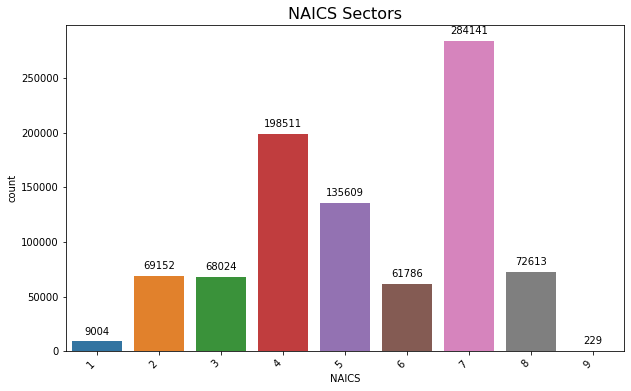

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x =loans['NAICS'] )
plt.title("NAICS Sectors",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

**RevLineCr**, or Revolving Line of Credit should have values coded "Y" or "N".  We can see that there are 18 categories when there should be two.  All values coded "0" were converted to "N"; all values with "1" were coded to "Y", and all character values were coded as "N".  A plot below confirms that after cleaning that there are two classes.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

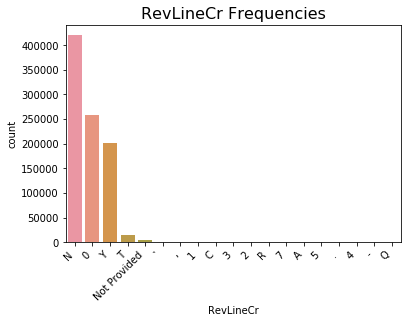

In [20]:
# RevLineCredit: delete special characters 14 total, recode numbers to letters
ax = sns.countplot(x =loans['RevLineCr'] )
plt.title("RevLineCr Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

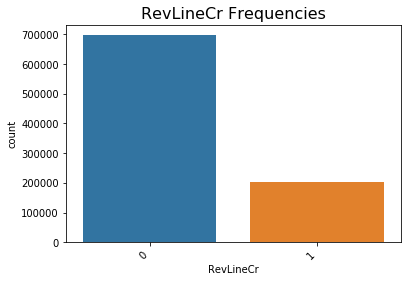

In [21]:
loans['RevLineCr'].replace(to_replace = ['Y','1'], value = 1, inplace = True)
loans['RevLineCr'].replace(to_replace = ['N','0'], value = 0, inplace = True)
no = ['T','`','Not Provided',",",'C','3','2','R','7','A','5','.','4',"'",'Q','-']
loans['RevLineCr'].replace(to_replace = no, value = 0, inplace = True)

ax = sns.countplot(x =loans['RevLineCr'] )
plt.title("RevLineCr Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

**LowDoc** has 9 categories when it should have 3.  All values with "Y" will be coded as 1; values with "N" will be coded as 0; all other values will be coded as 0.  We can see that most loan applicants are not part of the LowDoc loan program in the barchart below.  After reorganization we can see that there are 2 categories with 0 being the largest with 788,817 records.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

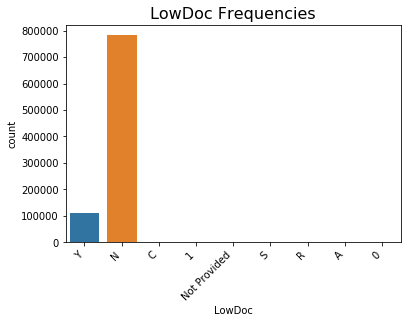

In [22]:
# LowDoc: covert everything to Y or N
ax = sns.countplot(x =loans['LowDoc'] )
plt.title("LowDoc Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

In [23]:
loans['LowDoc'].replace(to_replace = ['Y','1'], value = 1, inplace = True)
loans['LowDoc'].replace(to_replace = ['N','0'], value = 0, inplace = True)
no = ['C','S','Not Provided','S','R','A']
loans['LowDoc'].replace(to_replace = no, value = 0, inplace = True)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

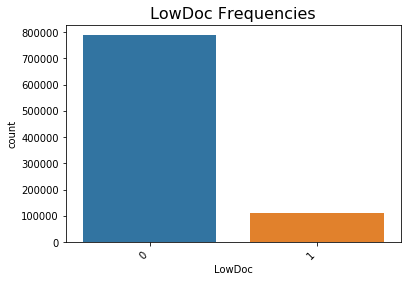

In [24]:
ax = sns.countplot(x =loans['LowDoc'] )
plt.title("LowDoc Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

**FRANCHISE CODE** is a feature that describes if a business is a franchise or not and is denoted with '0' being no, and '1' being yes.  All records that were not coded as '0' were recoded to '1'.  Some examples of this would be records with 'Y', which would then be recoded to '1'.  The plot below confirms the cleaning and that two classes remain.

C:\Users\Jeff\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(array([0, 1]), <a list of 2 Text xticklabel objects>)

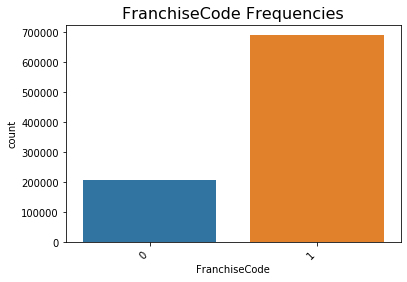

In [25]:
loans['FranchiseCode'].loc[(loans['FranchiseCode'] !=0)] = 1

ax = sns.countplot(x =loans['FranchiseCode'] )
plt.title("FranchiseCode Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

There are over 50 categories for the **State** feature, where each category is a state or military address.  If all the states were converted via one-hot-encoding, or dummy coding, there would be a risk of overfitting.  To address this states will be grouped into the following regions: West, Midwest, Southwest, Southeast, and Northeast.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]),
 <a list of 53 Text xticklabel objects>)

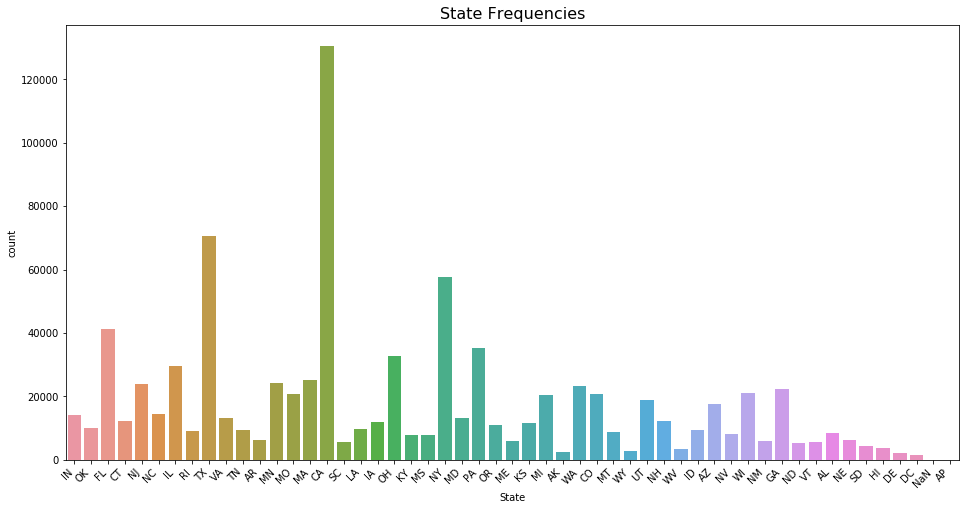

In [26]:
# State Distribution
plt.figure(figsize=(16,8))
ax = sns.countplot(x =loans['State'] )
plt.title("State Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

After the **State** feature was binned by region, we can see that the 'West' has the most loan applocations, followed by the 'Northeast' and 'Midwest'.  The code below assigns each state to a region based on this map found on National Geographic:https://www.nationalgeographic.org/maps/united-states-regions/

The binning was confirmed by a barchart to ensure that all states were properly assigned to a region.  The barchart include frequency counts for ease of reading and was generated using a for loop.

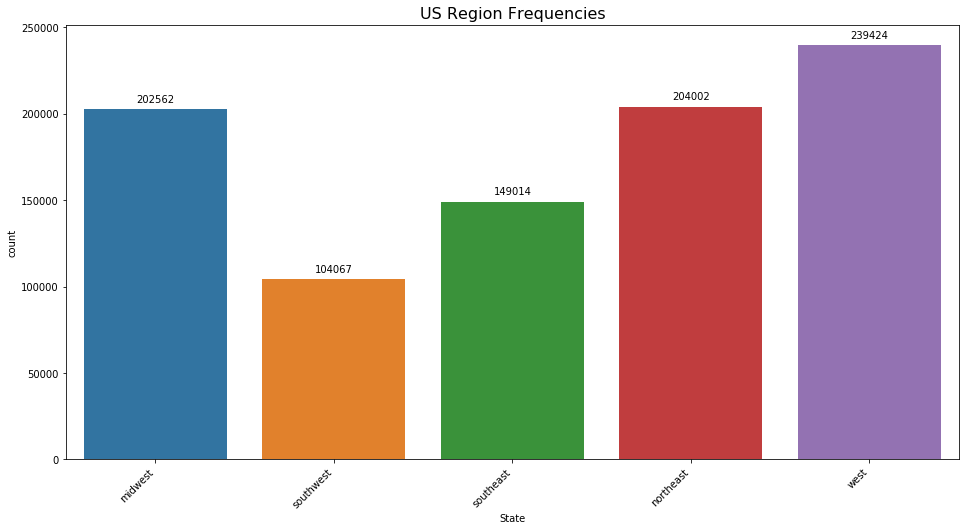

In [27]:
#Generate list of states
west = ['WA','OR','CA','NV','UT','CO','WY','MT','ID','AK','HI','AP','NaN']
midwest =['ND','SD','NE','KS','MO','IA','MN','MI','IL','IN','OH','WI']
southeast = ['AR','LA','MS','TN','KY','WV','VA','NC','SC','GA','FL','AL']
southwest = ['AZ','TX','NM','OK']
northeast = ['ME','VT','NH','CT','RI','NY','NJ','DE','MD','MA','PA','DC']

loans['State'].replace(to_replace = west, value = 'west', inplace = True)
loans['State'].replace(to_replace = midwest, value = 'midwest', inplace = True)
loans['State'].replace(to_replace = southeast, value = 'southeast', inplace = True)
loans['State'].replace(to_replace = southwest, value = 'southwest', inplace = True)
loans['State'].replace(to_replace = northeast, value = 'northeast', inplace = True)

plt.figure(figsize=(16,8))
ax = sns.countplot(x =loans['State'] )
plt.title("US Region Frequencies",fontsize= 16)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')

for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

#### Categorical One-hot-encoding

**Bank**, **NAICS**, **ApprovalFY_decade**, **UrbanRural**, **NewExist**, and **State** are nominal categorical features and are best represented by one-hot-encoding or as an integer.  For our models, these features will be converted to on hot encoding and the old feature will be removed.  After one-hot-encoding was complete, the .info() function was run to visually check to ensure that the function created new features and removed the old features.  Failure to remove features used to create on-hot-encoded features would introduce multicollinearity.  This property would result in an over-inflation of model metrics.

In [28]:
# loans = pd.get_dummies(loans,columns=['Bank','NAICS', 'UrbanRural','NewExist','State'])

# #Clean up dataset
# if 'Bank' in loans:
#     del loans['Bank']
    
# if 'NAICS' in loans:    
#     del loans['NAICS']
    
# if 'State' in loans:    
#     del loans['State']  

# if 'UrbanRural' in loans:    
#     del loans['UrbanRural']  
        
# if 'NewExist' in loans:    
#     del loans['NewExist']  

In [29]:
loans = loans.reset_index(drop=True) #resets index, important when converting to array

In [30]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899069 entries, 0 to 899068
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LoanNr_ChkDgt       899069 non-null  int64         
 1   Name                899069 non-null  object        
 2   City                899069 non-null  object        
 3   State               899069 non-null  object        
 4   Zip                 899069 non-null  object        
 5   Bank                899069 non-null  object        
 6   BankState           899069 non-null  object        
 7   NAICS               899069 non-null  category      
 8   ApprovalDate        899069 non-null  datetime64[ns]
 9   ApprovalFY          899069 non-null  object        
 10  Term                899069 non-null  int64         
 11  NoEmp               899069 non-null  int64         
 12  NewExist            899069 non-null  Int64         
 13  CreateJob           899069 no

After additional cleaning and binning of the categorical features we can see that the number of unique levels has decreased.  Having fewer levels per features should reduce the computational load and potential overfitting when running our classification algorithms.

### Quantitative Features

The correlation matrix below shows continuous features that help determine if a loan is paid in full or if it defaults.  The correlation matrix shows that **DisbursementGross** is strongly and positively with **SBA_Appr** and **GrAppv**; and **SBA_Appr** is strongly and positively correlated with **GrAppv**. **NoEmp** and **Term** feature show moderate or low correlation compared to the remaining features. **DisbursementGross**, **SBA_Appr** and **GrAppv** all relate to the amount of money a small business is approved for or received and the correlation matrix shows how strongly correlated those values are. It is most likely that values from DisbursementGross, **SBA_Appr** and **GrAppv** are the same or are very close to each other.

One assumption for logistic regression is minimal multicollinearity.  **DisbursmentGross**, **GRAppv**, and **SBA_Appv** are highly correlated (r > 0.90) with each other as they all describe the amount of money that is given to a loan applicant.  Since the **SBA_Appv** feature describes the amount of money that is approved and guaranteed to an applicant it will be kept.  **DisbursementGross** and **GrAppv** will be removed as they are both like **SBA_Appv**, but do not represent the final loan amount an applicant will receive.

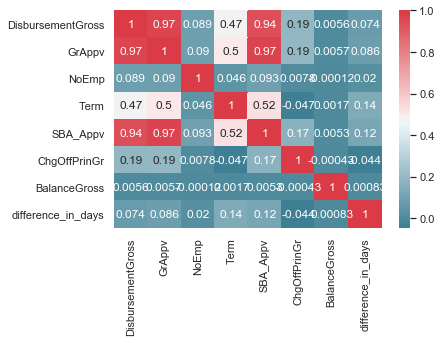

In [31]:
normal_data =['DisbursementGross', 'GrAppv', 'NoEmp', 'Term', 'SBA_Appv','ChgOffPrinGr', 
              'BalanceGross','BankState','difference_in_days']
loans_corr = loans[normal_data]

cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

#Generate a correlation matrix of transformed data
sns.set(style="darkgrid") # one of the many styles to plot using
sns.heatmap(loans_corr.corr(), cmap=cmap, annot=True)

# Data Understanding 2

In [32]:
defaults = loans[loans['MIS_Status']==0]
defaults = defaults.reset_index(drop=True)
default_features = ['State','NAICS','Term','SBA_Appv']

chg_off_data = defaults[default_features]

chg_off_data = pd.get_dummies(chg_off_data,columns=['NAICS','State'])

if 'NAICS' in chg_off_data:    
    del chg_off_data['NAICS']
    
if 'State' in chg_off_data:    
    del chg_off_data['State']  
    
chg_off_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157818 entries, 0 to 157817
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Term             157818 non-null  int64  
 1   SBA_Appv         157818 non-null  float64
 2   NAICS_1          157818 non-null  uint8  
 3   NAICS_2          157818 non-null  uint8  
 4   NAICS_3          157818 non-null  uint8  
 5   NAICS_4          157818 non-null  uint8  
 6   NAICS_5          157818 non-null  uint8  
 7   NAICS_6          157818 non-null  uint8  
 8   NAICS_7          157818 non-null  uint8  
 9   NAICS_8          157818 non-null  uint8  
 10  NAICS_9          157818 non-null  uint8  
 11  State_midwest    157818 non-null  uint8  
 12  State_northeast  157818 non-null  uint8  
 13  State_southeast  157818 non-null  uint8  
 14  State_southwest  157818 non-null  uint8  
 15  State_west       157818 non-null  uint8  
dtypes: float64(1), int64(1), uint8(14)
mem

In [34]:
#Standardize Data
%matplotlib inline
# chg_off_data['NAICS']= chg_off_data['NAICS'].astype(float)

y = chg_off_data['SBA_Appv']
chg_off_data['SBA_Appv_std'] =(chg_off_data['SBA_Appv'] - chg_off_data['SBA_Appv'].mean())/chg_off_data['SBA_Appv'].std()
#defaults[['SBA_Apprv_std']]

X1 = chg_off_data[['Term','SBA_Appv_std']].values

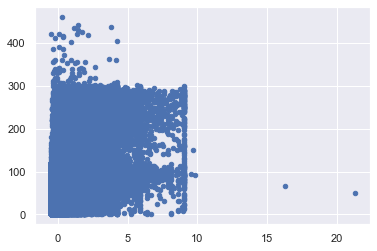

In [35]:
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, s=20)

Create CV object

# Modeling and Evaluation 1

### DBSCAN

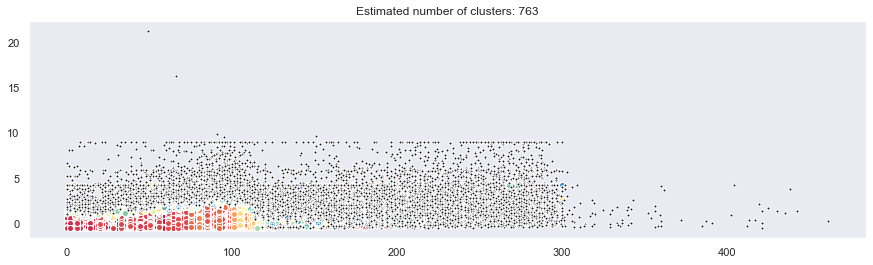

In [36]:
from sklearn.cluster import DBSCAN

#=====================================
# ENTER YOUR CODE HERE TO CHANGE MINPTS AND EPS FOR EACH DATASET
X1_minpts = 5 # from above
X1_eps = 0.1
#=====================================

for i, (data, minpts, eps) in enumerate(zip([X1],[X1_minpts],[X1_eps])):

    db = DBSCAN(eps=eps, min_samples=minpts).fit(data)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # mark the samples that are considered "core"
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=(15,4))
    unique_labels = set(labels) # the unique labels
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        # plot the core points in this class
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.grid()
    plt.show()

### Agglomerative

In [89]:
from sklearn import manifold
from scipy.cluster.hierarchy import dendrogram

clustering = chg_off_data
X12=clustering.sample(n=20000, replace=False, random_state=1)

# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [120]:
#Dimensionality Reduciton
#----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=15, n_jobs=-1).fit_transform(X12)
print("Done.")

Computing embedding
Done.


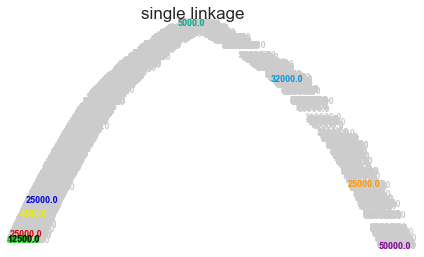

In [134]:
from sklearn.cluster import AgglomerativeClustering
linkage = 'single'
#for linkage in ('single','ward'):
cluster_model = AgglomerativeClustering(linkage='single',distance_threshold=0, n_clusters=None)
cluster_model.fit(X_red)

plot_clustering(X_red, cluster_model.labels_, "%s linkage" % linkage)
plt.show()

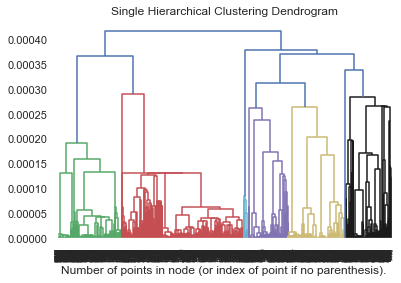

In [135]:
plt.title('Single Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(cluster_model, truncate_mode='level', p=15)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

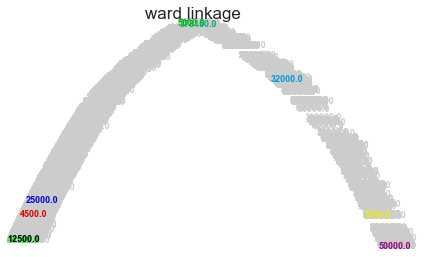

In [131]:
#for linkage in ('single','ward'):
cluster_model = AgglomerativeClustering(linkage='ward',distance_threshold=0, n_clusters=None)
cluster_model.fit(X_red)

plot_clustering(X_red, cluster_model.labels_, "%s linkage" % linkage)
plt.show()

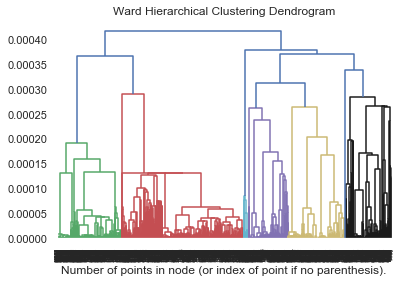

In [136]:
plt.title('Ward Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(cluster_model, truncate_mode='level', p=15)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

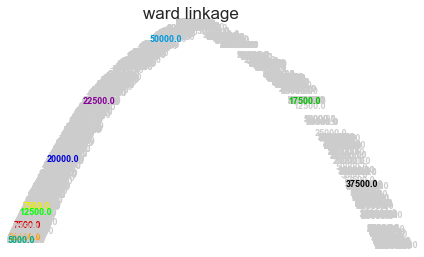

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X_red, test_size=0.2, random_state=42)
cluster_model2 = AgglomerativeClustering(linkage='ward',distance_threshold=0, n_clusters=None)
cluster_model2.fit(X_train)
predictions = cluster_model2.fit_predict(X_test)
plot_clustering(X_test, cluster_model2.labels_, "%s linkage" % linkage)
plt.show()                                         


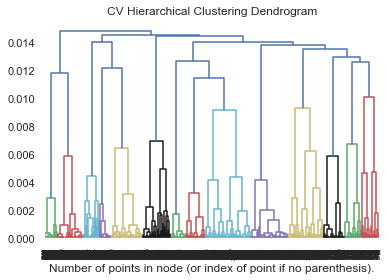

<Figure size 576x1080 with 0 Axes>

In [125]:
from matplotlib.pyplot import figure
plt.title('CV Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(cluster_model2, truncate_mode='level', p=15)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.xticks(rotation=90)
figure(figsize=(8,15))
plt.show()

# Modeling and Evaluation 2

# Modeling and Evaluation 3

# Modeling and Evaluation 4

# Deployment

# Exceptional Work

We would like to have the following considered for exceptional work:
1. The creation of a gridsearch() helper function that preforms grid-search for hyperparameter tunning, and displays a plot of f1-score per response class;  additionally this helper function is able to be used for both regression and classifcation tasks.
2. We have a separate hold-out set for final model testing to prevent "model-doping" or the potenial of mixing training and test data from a standard CV process.
3. Creation of MTAS metric and utilizing make_scorer so that it was accessable to sklearn and mlextend funcitons 
4. T-Test for models in addition to ROC curves